In [10]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, Dict, Iterable, Literal, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from qresearch.data.io import load_hsci_2008_components, load_hsci_components_history, load_market_data_from_parquet
from qresearch.data.types import MarketData
from qresearch.data.utils import get_processed_dir, save_market_data_to_csv, load_market_data_from_csv
from qresearch.data.yfinance import download_market_data

from qresearch.backtest.visualise import visualize_from_rep, FactorVizConfig
from qresearch.signals import get_signal

from qresearch.signals.transforms import neutralize_sector, sector_series_to_df, neutralize_sector_and_mcap_fwl
from qresearch.universe.hsci import canon_hk_ticker, build_hsci_events_from_history
from qresearch.data.io import load_market_data_from_parquet, load_historical_mcap_parquet, load_hsci_2008_components, \
    load_hsci_components_history, load_estimated_shares

from qresearch.universe.builder import build_final_universe_eligible
from qresearch.universe.filters import UniverseFilterConfig

In [12]:
history_df = load_hsci_components_history("hsci_components_history.csv")  # processed
events = build_hsci_events_from_history(history_df)

snap2008 = load_hsci_2008_components("hsci_components_2008.csv")  # raw
seed_members = set(
    snap2008["Stock Code"]
    .map(canon_hk_ticker)
    .dropna()
    .astype(str)
    .unique()
)

md = load_market_data_from_parquet(get_processed_dir() / 'market/hsci_ohlc.parquet')
mcap = load_historical_mcap_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')

shares_map = load_estimated_shares(get_processed_dir() / 'fundamentals' / 'hsci_estimated_shares.parquet')

def make_shares_panel(md: "MarketData", shares_map: pd.Series) -> pd.DataFrame:
    close = md.close.sort_index()
    # align tickers
    s = shares_map.reindex(close.columns)
    # repeat across dates
    shares_panel = pd.DataFrame(
        np.tile(s.values, (len(close.index), 1)),
        index=close.index,
        columns=close.columns,
    )
    return shares_panel

shares_panel = make_shares_panel(md, shares_map)
md.shares_outstanding = make_shares_panel(md, shares_map)
md.mkt_cap = pd.read_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')

uf_cfg = UniverseFilterConfig(
    ma_window=21,
    min_ma_price=1,      # None disables
    mcap_window=21,
    min_mean_mcap=1e9,     # None disables; requires mcap if not None
    min_ipo_trading_days=63,  # 0 disables
)

universe_eligible = build_final_universe_eligible(
    close=md.close,
    events=events,                # membership gating ON
    seed_members=seed_members,
    cfg=uf_cfg,
    mcap=mcap,                    # required if min_mean_mcap is not None
    effective_on_close=True,
)
# universe_eligible: bool DataFrame (date x ticker)

hsci_sector_map = pd.read_csv(get_processed_dir() / 'hsci_sector_map_yf.csv', index_col=0)
hsci_market_cap = load_historical_mcap_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')
sector_df = sector_series_to_df(hsci_sector_map, dates=md.close.index, tickers=hsci_sector_map.index)

# benchmark
# hsi = yf.download('^HSI', start=md.close.index[0], end=md.close.index[-1])

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_96621/3935892315.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hsi = yf.download('^HSI', start=md.close.index[0], end=md.close.index[-1])
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^HSI']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [13]:
from qresearch.signals.registry import compute_signal
from qresearch.backtest.buckets import make_tearsheet

good_signals = [
    ("trend_annret_r2", {"lookback": 252, "ann_factor": 252, 'skip': 21}),
    ('vol_highlow_std_3M', {}),
    ('liq_amihud_std_3M', {'sign': -1}),
]

# sig = compute_signal(md, name="trend_annret_r2", lookback=252, ann_factor=252, skip=21)
# sig = sig.reindex(index=md.close.index, columns=md.close.columns)

# rep = make_tearsheet(
#     md=md,
#     signal=sig,
#     H=20,
#     n_buckets=10,
#     entry_mode="next_close",
#     min_assets_ic=50,
#     plot=True,
#     # benchmark_price=hsi,
#     # benchmark_name="^HSI",
#     universe_eligible=universe_eligible,  # critical
# )

In [22]:
from typing import List


# ============================================================
# 0) Core utilities: naming + label/feature building
# ============================================================
def ensure_names(close_df: pd.DataFrame) -> pd.DataFrame:
    close = close_df.sort_index().copy()
    close.index = pd.to_datetime(close.index)
    close.index.name = "date"
    close.columns.name = "ticker"
    return close


def make_fwd_return(close_df: pd.DataFrame, H: int = 5) -> pd.DataFrame:
    close = ensure_names(close_df)
    return close.shift(-H) / close - 1.0


def rsi_wilder(close: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    delta = close.diff()
    up = delta.clip(lower=0.0)
    down = (-delta).clip(lower=0.0)
    roll_up = up.ewm(alpha=1 / period, adjust=False).mean()
    roll_down = down.ewm(alpha=1 / period, adjust=False).mean()
    rs = roll_up / roll_down
    return 100.0 - (100.0 / (1.0 + rs))


def make_features(md: MarketData, signals: List[Tuple[str, dict]] = None) -> Dict[str, pd.DataFrame]:
    if signals is None:
        close = md.close
        ma5 = close.rolling(5).mean()
        ma10 = close.rolling(10).mean()
        ma20 = close.rolling(20).mean()
    
        close_ma_diff_5 = close / ma5 - 1.0
        close_ma_diff_10 = close / ma10 - 1.0
        close_ma_diff_20 = close / ma20 - 1.0
    
        max_growth_5 = close / close.shift(5) - 1.0
    
        rsi = rsi_wilder(close, period=14)
    
        roll_max_120 = close.rolling(120).max()
        dd = close / roll_max_120 - 1.0
        max_drawdown_120 = dd.rolling(120).min()
    
        return {
            "close_ma_diff_5": close_ma_diff_5,
            "max_growth_5": max_growth_5,
            "close_ma_diff_10": close_ma_diff_10,
            "rsi": rsi,
            "close_ma_diff_20": close_ma_diff_20,
            "max_drawdown_120": max_drawdown_120,
        }
    features = {}
    for signal_name, params in signals:
        features[signal_name] = compute_signal(md, name=signal_name, **params)
        
    return features


def wide_to_panel(features: Dict[str, pd.DataFrame], y_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Convert wide feature dict + wide y into a long panel:
    columns: date, ticker, <feature...>, y
    """
    parts = []
    for name, df in features.items():
        s = df.stack(future_stack=True).rename(name)
        parts.append(s)

    X = pd.concat(parts, axis=1)
    y = y_wide.stack(future_stack=True).rename("y")

    panel = pd.concat([X, y], axis=1)
    panel.index = panel.index.set_names(["date", "ticker"])
    panel = panel.reset_index()
    panel["date"] = pd.to_datetime(panel["date"])
    return panel


# ============================================================
# 1) Cross-sectional preprocessing
# ============================================================
def cs_winsorize_zscore(panel: pd.DataFrame, feature_cols: list[str], q_lo: float = 0.01, q_hi: float = 0.99) -> pd.DataFrame:
    out = panel.copy()
    for c in feature_cols:
        g = out.groupby("date")[c]
        lo = g.transform(lambda s: s.quantile(q_lo))
        hi = g.transform(lambda s: s.quantile(q_hi))
        x = out[c].clip(lo, hi)
        mu = x.groupby(out["date"]).transform("mean")
        sd = x.groupby(out["date"]).transform("std")
        out[c] = (x - mu) / sd
        
    return out


def flip_negative_ic(panel: pd.DataFrame, feature_cols: list[str]) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Pooled Spearman IC between each feature and y.
    If IC < 0, flip sign to enforce positive direction.
    """
    out = panel.copy()
    ic_map: Dict[str, float] = {}
    for c in feature_cols:
        ic = out[c].corr(out["y"], method="spearman")
        ic_map[c] = float(ic) if ic is not None else np.nan
        if ic is not None and ic < 0:
            out[c] = -out[c]
    return out, ic_map


# ============================================================
# 2) Walk-forward split (2y train / 1m test + purge H)
# ============================================================
def walk_forward_splits(
    dates: Iterable[pd.Timestamp],
    train_years: int = 2,
    test_months: int = 1,
    H: int = 5,
    min_train_days: int = 100,
    min_test_days: int = 5,
):
    dates = pd.DatetimeIndex(sorted(pd.DatetimeIndex(dates).unique()))
    start = dates.min()
    end = dates.max()

    cur_test_start = start + pd.DateOffset(years=train_years)
    while cur_test_start < end:
        cur_test_end = cur_test_start + pd.DateOffset(months=test_months)

        test_dates = dates[(dates >= cur_test_start) & (dates < cur_test_end)]
        if len(test_dates) == 0:
            cur_test_start = cur_test_end
            continue

        test_start = test_dates.min()
        pos = dates.get_indexer([test_start])[0]
        train_end_pos = max(pos - H, 0)  # purge H days
        train_end = dates[train_end_pos]

        train_start = test_start - pd.DateOffset(years=train_years)
        train_dates = dates[(dates >= train_start) & (dates <= train_end)]

        if len(train_dates) >= min_train_days and len(test_dates) >= min_test_days:
            yield train_dates, test_dates

        cur_test_start = cur_test_end


# ============================================================
# 3) Model adapters (single interface)
# ============================================================
@dataclass(frozen=True)
class FitPredictContext:
    feature_cols: list[str]
    top_k: int
    H: int


FitPredictFn = Callable[
    [pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray, FitPredictContext, dict],
    np.ndarray
]
"""
Signature:
    predict = fit_predict(
        train_df, test_df,
        X_train, y_train, group_train,
        X_test, group_test,
        ctx, params
    )
"""

def make_relevance_from_y(
    panel: pd.DataFrame,
    n_bins: int = 5,
    col_y: str = "y",
    col_date: str = "date",
    min_per_day: int = 20,
) -> pd.Series:
    """
    Convert continuous forward returns y into integer relevance labels per day.

    Why:
    - LightGBM LambdaRank expects integer labels (relevance grades).
    - Relevance must be cross-sectional per query group (here: per date).

    Robustness:
    - Handles ties / insufficient unique values / small universes.
    - Guarantees output is integer in [0, n_bins-1] where defined.
    - Returns pd.Series aligned to panel.index (same length).

    Convention:
    - Higher y => higher relevance (better).
    """
    if n_bins < 2:
        raise ValueError("n_bins must be >= 2")

    y = panel[col_y]
    d = panel[col_date]

    def _bin_one_day(s: pd.Series) -> pd.Series:
        # s is y for one date, indexed by panel index rows
        s = s.replace([np.inf, -np.inf], np.nan).dropna()

        # Not enough names to create stable bins
        if len(s) < max(min_per_day, n_bins):
            return pd.Series(index=s.index, data=np.nan)

        # If too many ties (e.g., many zeros), qcut can fail or drop bins
        # Strategy: rank then map ranks into bins deterministically.
        r = s.rank(method="average")  # ascending rank: low y -> small rank
        # Convert rank percentiles to bins
        # bin_id in 0..n_bins-1
        bin_id = np.floor((r - 1) / max(len(r) / n_bins, 1.0))
        bin_id = bin_id.clip(0, n_bins - 1)

        # Ensure integer dtype but allow NaN at higher level; return Int64 for safety
        return pd.Series(index=s.index, data=bin_id.astype(np.int64))

    rel = panel.groupby(d, sort=False)[col_y].apply(_bin_one_day)
    # groupby/apply returns a multiindex series; drop the group level so it aligns with original rows
    rel = rel.reset_index(level=0, drop=True)

    # Align to full panel index: rows that were NaN/dropped become NaN here
    rel = rel.reindex(panel.index)

    # Use pandas nullable Int64 to avoid int-casting NaN error.
    return rel.astype("Int64")


def fit_predict_xgb_ranker(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    X_train: np.ndarray,
    y_train: np.ndarray,
    group_train: np.ndarray,
    X_test: np.ndarray,
    group_test: np.ndarray,
    ctx: FitPredictContext,
    params: dict,
) -> np.ndarray:
    from xgboost import XGBRanker

    # map friendly params -> XGBRanker init
    model = XGBRanker(**params)
    model.fit(X_train, y_train, group=group_train)
    return model.predict(X_test)


def fit_predict_lgb_lambdarank(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    X_train: np.ndarray,
    y_train: np.ndarray,
    group_train: np.ndarray,
    X_test: np.ndarray,
    group_test: np.ndarray,
    ctx: FitPredictContext,
    params: dict,
) -> np.ndarray:
    import lightgbm as lgb

    # LightGBM needs Dataset + group
    dtrain = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=True)
    dvalid = lgb.Dataset(X_test,  label=np.zeros_like(X_test[:, 0]), group=group_test, reference=dtrain, free_raw_data=True)

    # training params
    lgb_params = params.get("lgb_params", {})
    num_boost_round = params.get("num_boost_round", 2000)
    early_stopping_rounds = params.get("early_stopping_rounds", 50)

    # ensure objective/metric exist
    lgb_params = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "verbosity": -1,
        "ndcg_eval_at": [ctx.top_k],
        **lgb_params,
    }

    booster = lgb.train(
        lgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        valid_sets=[dvalid],
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)],
    )
    return booster.predict(X_test, num_iteration=booster.best_iteration)


MODEL_REGISTRY: Dict[str, FitPredictFn] = {
    "xgb_ranker": fit_predict_xgb_ranker,
    "lgb_lambdarank": fit_predict_lgb_lambdarank,
}


# ============================================================
# 4) Shared evaluation
# ============================================================
def eval_rankic(oos: pd.DataFrame) -> Dict[str, object]:
    rankic_by_day = oos.groupby("date", group_keys=False)[["score", "y"]].apply(lambda g: g["score"].corr(g["y"], method="spearman"))
    mean = float(rankic_by_day.mean())
    std = float(rankic_by_day.std(ddof=0))
    ir = float(mean / std) if std > 0 else np.nan
    return {"rankic_by_day": rankic_by_day, "rankic_mean": mean, "rankic_ir": ir}


def eval_topk_proxy(oos: pd.DataFrame, top_k: int) -> Dict[str, object]:
    # Diagnostic only: mean of forward H-day return y among top-k scores
    topk_fwd = oos.groupby("date", group_keys=False)[["score", "y"]].apply(lambda g: g.nlargest(top_k, "score")["y"].mean())
    topk_eq = (1 + topk_fwd.fillna(0)).cumprod()
    return {"topk_fwd": topk_fwd, "topk_fwd_eq": topk_eq}


# ============================================================
# 5) The unified workflow (minimal duplication)
# ============================================================
def run_rank_workflow(
    md: MarketData,
    signals,
    model_name: Literal["xgb_ranker", "lgb_lambdarank"],
    model_params: dict,
    H: int = 5,
    top_k: int = 7,
    train_years: int = 2,
    test_months: int = 1,
    preprocess: bool = True,
    align_feature_sign: bool = True,
) -> Dict[str, object]:
    """
    Unified workflow for cross-sectional ranking models (walk-forward).

    Inputs
    ------
    close_df:
        Wide close price table: index=Date, columns=Ticker.
        Features and y are computed using only information up to close[t].
    model_name:
        Which ranker to use (delegated to MODEL_REGISTRY).
    model_params:
        Model-specific parameters, plus optional workflow knobs like:
          - relevance_bins (for lgb_lambdarank)
    H:
        Forward horizon: y[t] = fwd return over the holding window aligned to entry rule.
    top_k:
        Used by eval_topk_proxy (diagnostic), and can be used by the ranker objective.
    train_years / test_months:
        Walk-forward split definition.
    preprocess:
        Cross-sectional winsorize + zscore per date (recommended).
    align_feature_sign:
        Flip features with negative pooled IC so “higher is better” consistently.

    Returns
    -------
    dict with:
        - pooled_ic (optional)
        - oos (long panel of predictions)
        - oos_wide (date x ticker score table; directly usable as a signal)
        - rankic stats
        - topk proxy stats
        - metadata
    """
    if model_name not in MODEL_REGISTRY:
        raise KeyError(f"Unknown model_name={model_name}. Available: {list(MODEL_REGISTRY.keys())}")

    fit_predict = MODEL_REGISTRY[model_name]

    # -------------------------
    # 1) Build a single shared panel: (date, ticker) rows with features + y
    # -------------------------
    feats = make_features(md, signals)
    y_wide = make_fwd_return(md.close, H=H)

    panel = wide_to_panel(feats, y_wide)  # expects columns: date, ticker, <features...>, y

    feature_cols = list(feats.keys())

    # Hard clean y to avoid inf contaminating downstream ops
    # (You can optionally extend to features, but you already dropna later.)
    panel = panel[np.isfinite(panel["y"].to_numpy())].copy()

    # -------------------------
    # 2) LightGBM LambdaRank needs integer relevance grades per query group (date)
    # -------------------------
    if model_name == "lgb_lambdarank":
        n_bins = int(model_params.get("relevance_bins", 5))
        panel = panel.copy()
        panel["rel"] = make_relevance_from_y(panel, n_bins=n_bins, col_y="y", col_date="date")

    # -------------------------
    # 3) Drop NA rows from rolling windows + end-of-sample horizon
    # -------------------------
    drop_cols = ["y"] + feature_cols
    if model_name == "lgb_lambdarank":
        # rel is allowed to be NA for bad dates; but training cannot.
        drop_cols += ["rel"]

    panel = panel.dropna(subset=drop_cols)

    # -------------------------
    # 4) Optional cross-sectional preprocessing (per date)
    # -------------------------
    if preprocess:
        panel = cs_winsorize_zscore(panel, feature_cols)

    pooled_ic = None
    if align_feature_sign:
        panel, pooled_ic = flip_negative_ic(panel, feature_cols)

    # Ensure chronological order for splits
    all_dates = pd.DatetimeIndex(panel["date"].unique()).sort_values()

    ctx = FitPredictContext(feature_cols=feature_cols, top_k=top_k, H=H)

    # -------------------------
    # 5) Walk-forward: train -> predict -> collect OOS scores
    # -------------------------
    oos_rows = []

    for train_dates, test_dates in walk_forward_splits(
        all_dates,
        train_years=train_years,
        test_months=test_months,
        H=H,
    ):
        train = panel[panel["date"].isin(train_dates)].sort_values(["date", "ticker"])
        test  = panel[panel["date"].isin(test_dates)].sort_values(["date", "ticker"])

        # Guard: skip empty splits (can happen if dates get filtered by NA drops)
        if len(train) == 0 or len(test) == 0:
            continue

        # Group sizes: one query group per date
        group_train = train.groupby("date").size().to_numpy()
        group_test  = test.groupby("date").size().to_numpy()

        X_train = train[feature_cols].to_numpy()
        X_test  = test[feature_cols].to_numpy()

        # y is always continuous forward return (kept for evaluation)
        y_test = test["y"].to_numpy()

        # For training target:
        # - XGB ranker can train directly on continuous y (pairwise)
        # - LGBM lambdarank typically expects relevance grades (int)
        if model_name == "lgb_lambdarank":
            y_train_model = train["rel"].to_numpy()
        else:
            y_train_model = train["y"].to_numpy()

        score = fit_predict(
            train, test,
            X_train, y_train_model, group_train,
            X_test, group_test,
            ctx, model_params,
        )

        tmp = test[["date", "ticker"]].copy()
        tmp["score"] = score
        tmp["y"] = y_test
        oos_rows.append(tmp)

    if not oos_rows:
        raise RuntimeError("No OOS rows produced. Check splits/NA filtering/universe coverage.")

    oos = (
        pd.concat(oos_rows, ignore_index=True)
        .sort_values(["date", "score"], ascending=[True, False])
    )

    # Wide score table: convenient “signal” to plug into bucket backtest / tearsheet
    oos_wide = oos.pivot(index="date", columns="ticker", values="score").sort_index()

    rank_metrics = eval_rankic(oos)
    topk_metrics = eval_topk_proxy(oos, top_k=top_k)

    return {
        "pooled_ic": pooled_ic,
        "oos": oos,
        "oos_wide": oos_wide,
        **rank_metrics,
        **topk_metrics,
        "model_name": model_name,
        "model_params": model_params,
        "H": H,
        "top_k": top_k,
        "train_years": train_years,
        "test_months": test_months,
        "preprocess": preprocess,
        "align_feature_sign": align_feature_sign,
    }


In [15]:
hsci_md = load_market_data_from_parquet(f'{get_processed_dir()}/market/hsci_ohlc.parquet')
hsci_md.close.head()

Ticker,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0008.HK,0010.HK,0011.HK,0012.HK,...,9987.HK,9988.HK,9990.HK,9991.HK,9992.HK,9993.HK,9995.HK,9996.HK,9997.HK,9999.HK
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,24.847145,25.940811,2.589432,2.421850,35.178757,14.836930,0.693667,12.779734,46.658382,7.983262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,26.171890,25.544769,2.589432,2.498910,35.407196,14.559281,0.661623,13.275274,45.945343,8.114780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,26.333448,25.445759,2.563708,2.443867,35.155895,14.593985,0.669163,13.979462,45.677982,8.469888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,25.444902,25.445759,2.559422,2.471387,34.265007,14.264276,0.659738,14.657570,44.563885,8.654012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08,24.734060,25.544769,2.585145,2.311766,33.808163,14.611338,0.688012,13.744731,45.276897,8.535645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
lgb_params = {
  "relevance_bins": 5,
  "lgb_params": {
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 300,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "min_gain_to_split": 0.0,
  },
  "num_boost_round": 800,
}

out = run_rank_workflow(
    md=hsci_md,
    signals=good_signals,
    model_name="lgb_lambdarank",
    model_params=lgb_params,
    H=5,
    top_k=20,
)

signal_ml = out["oos_wide"]  # date x ticker model scores

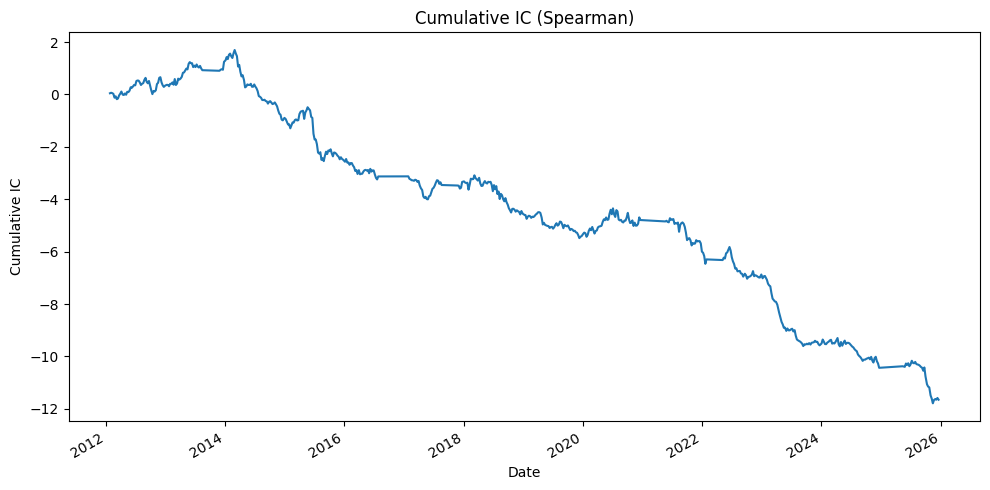

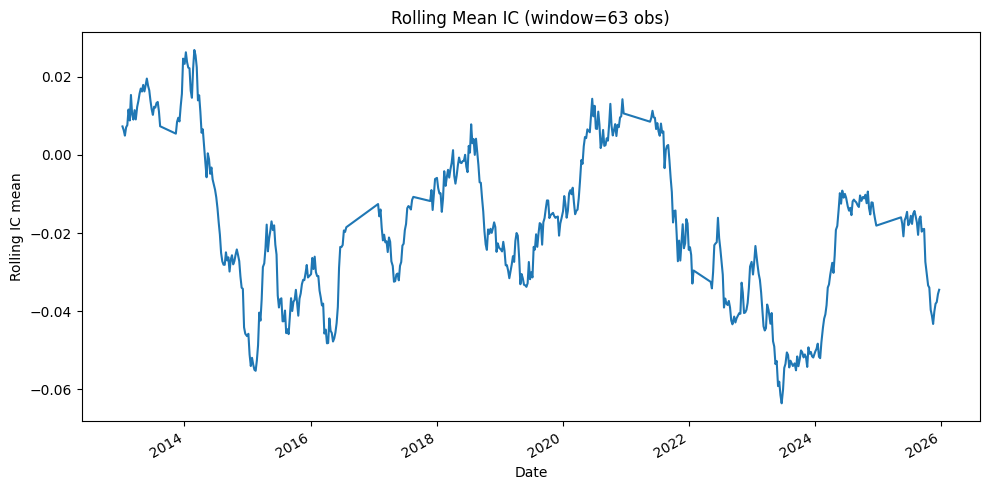

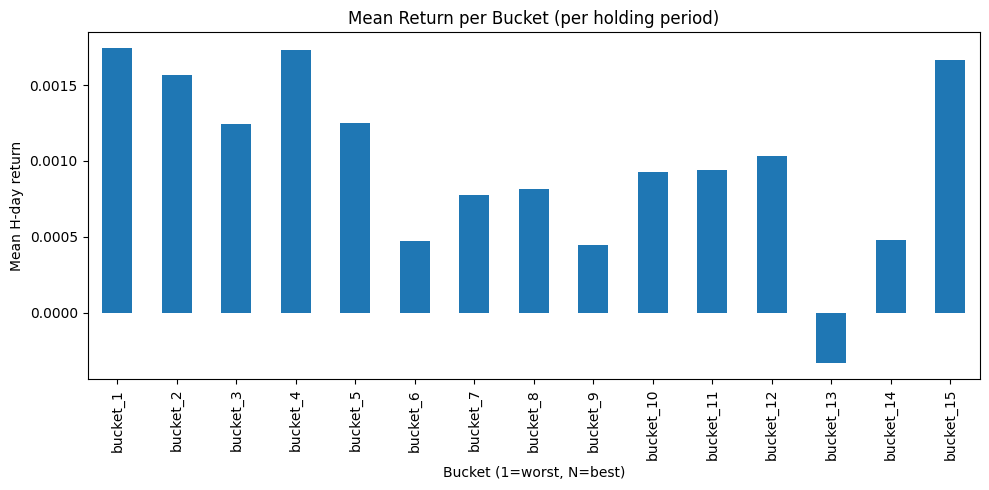

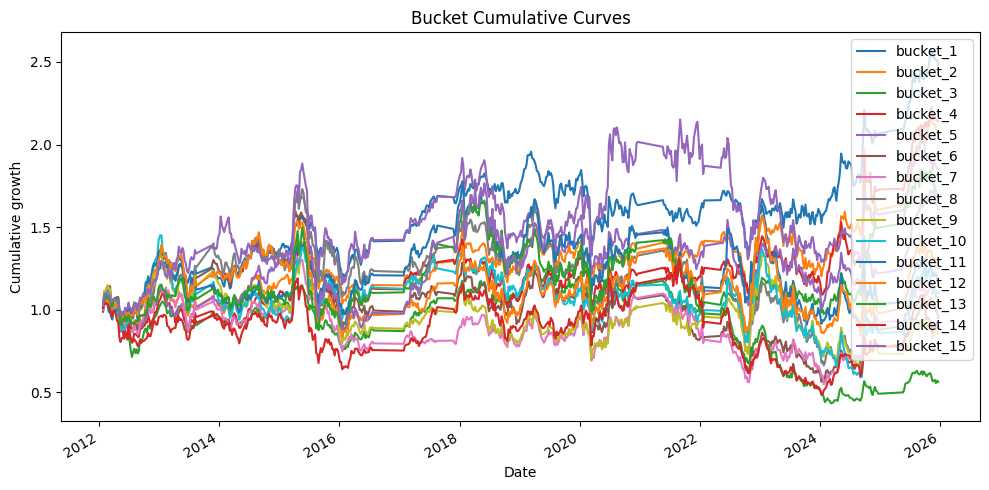

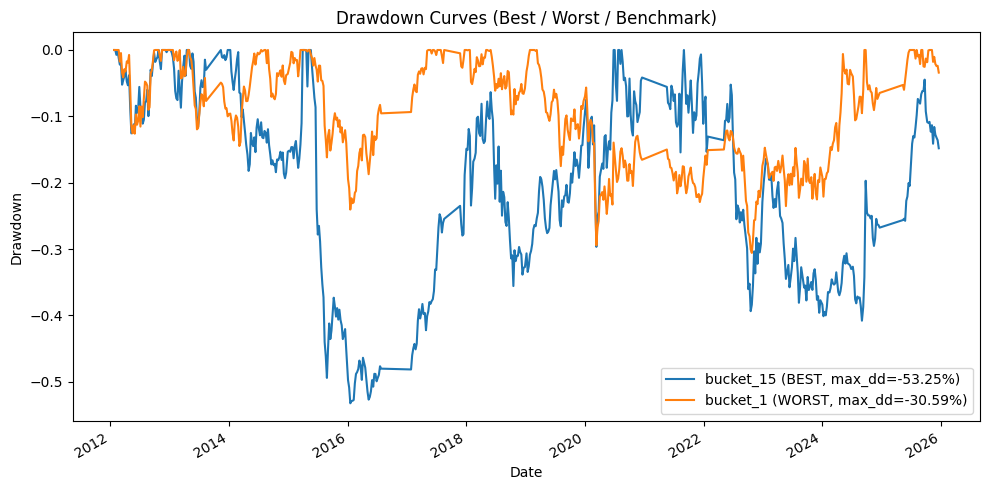

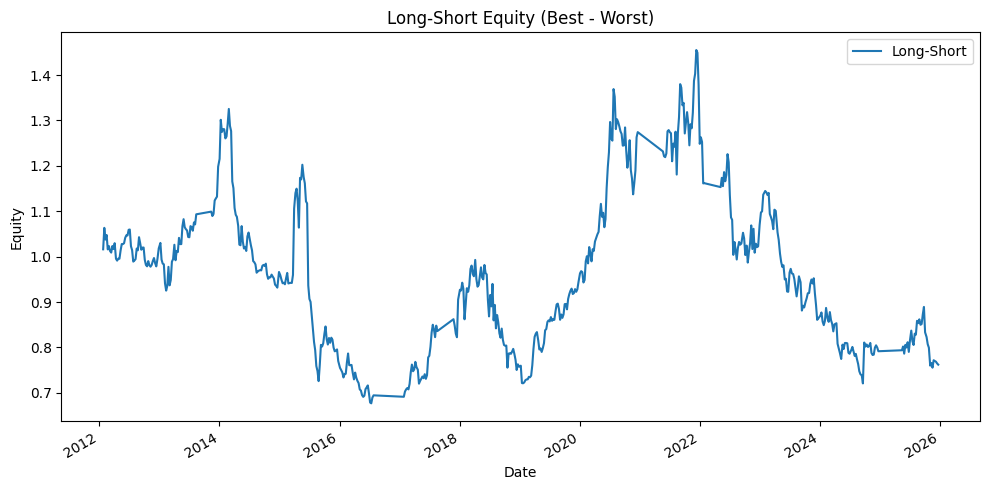

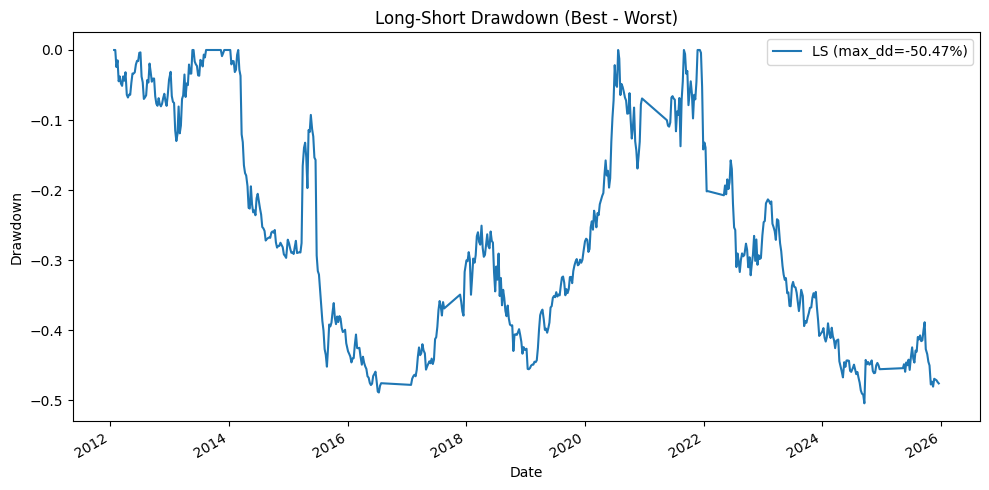

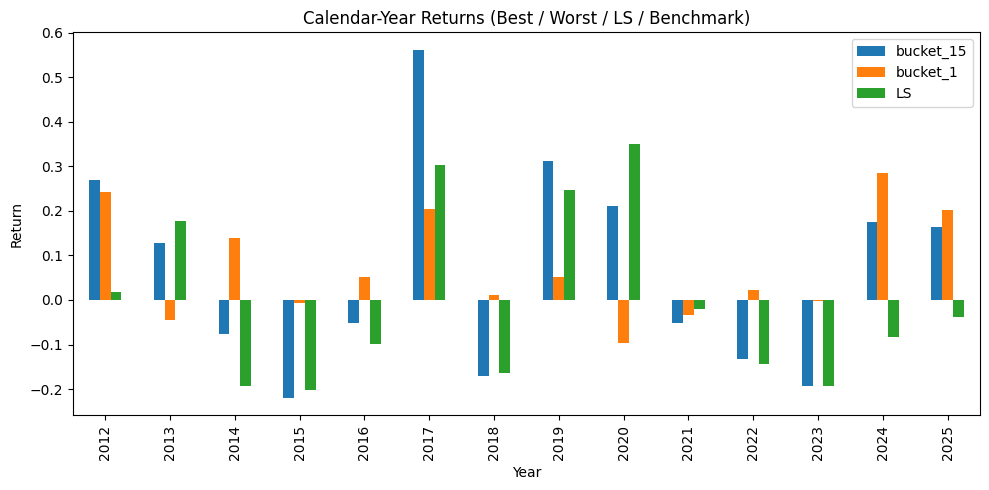

In [25]:
rep = make_tearsheet(
    md=md,
    signal=signal_ml,
    H=5,
    n_buckets=15,
    entry_mode="next_close",
    min_assets_ic=50,
    plot=True,
    # benchmark_price=hsi,
    # benchmark_name="^HSI",
    universe_eligible=universe_eligible, # critical
)

## Market Cap, Market Data

In [46]:
# from qresearch.universe.hsci import build_hsci_ticker_master
# 
# all_df = load_hsci_components_history()
# hsci_2008_df = load_hsci_2008_components()
# 
# hsci_ticker_master = build_hsci_ticker_master(all_df, hsci_2008_df)
# 
# tickers = hsci_ticker_master['ticker']
# 
# hsci_ticker_master

,ticker,in_seed_2008,in_history_events
0,0001.HK,True,True
1,0002.HK,True,False
2,0003.HK,True,False
3,0004.HK,True,True
4,0005.HK,True,False
...,...,...,...
929,9993.HK,False,True
930,9995.HK,False,True
931,9996.HK,False,True
932,9997.HK,False,True


In [10]:
# # ---- market data ----
# hsci_all_md = download_market_data(tickers, start=START_DATE, end=END_DATE)

In [49]:
# save_market_data_to_parquet(hsci_all_md, get_processed_dir() / 'market/hsci_ohlc.parquet')

In [1]:
# tickers = list(hsci_all_md.close.columns)
# 
# raw = download_mcap_snapshot_yf(tickers)
# snap = finalize_mcap_snapshot(raw, asof_date=hsci_all_md.close.index[-1])
# 
# shares = compute_estimated_shares(hsci_all_md.close, snap, px_asof=hsci_all_md.close.index[-1])
# mcap = build_historical_mcap(hsci_all_md.close, shares)


# save_mkt_cp_snapshot(snap, "data/processed/reference/hsci_mktcap_snapshot.parquet")

# save_estimated_shares(shares, "data/processed/reference/hsci_estimated_shares.parquet",
#                       asof_date=snap["asof_date"].iloc[0], px_asof_date=hsci_all_md.close.index[-1])


# save_historical_mcap_parquet(mcap, "data/processed/reference/hsci_mcap_approx.parquet")


In [54]:
# save_historical_mcap_parquet(historical_mcap, get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')

PosixPath('/Users/henrywzh/Desktop/Quant/Research/data/processed/fundamentals/hsci_mkt_cap.parquet')

In [58]:
# save_estimated_shares(estimated_shares, get_processed_dir() / 'fundamentals/hsci_estimated_shares.parquet')

PosixPath('/Users/henrywzh/Desktop/Quant/Research/data/processed/fundamentals/hsci_estimated_shares.parquet')